# Производим импорт всего необходимого

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from xgboost import XGBRFClassifier
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

Посмотрим на данные

In [2]:
df = pd.read_csv('train.csv')

Проводим проверку на пропуски данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [4]:
df.isnull().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

np.nan отсутствует, но я уже обучал модели и при обучении ловил предупреждение, что 
присутсвуют пропуски.

In [5]:
sum(df['TotalSpent'] == ' ')

9

проверим также на дупликаты 

In [6]:
df.duplicated().sum()

14

Избавляться от них не будит, так как падает качество модели

Особой связи между полом и уходом сказать  нельзя, так как это может быть несбалансированность данный

<AxesSubplot:xlabel='Churn', ylabel='count'>

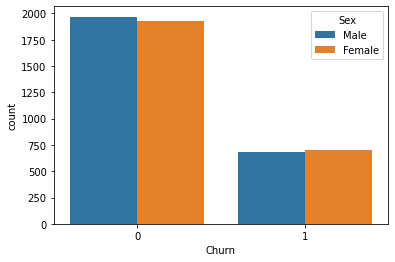

In [7]:
sns.countplot(x = 'Churn',hue='Sex', data= df)

Из этой диаграммы видно, что male ушло больше, чем female

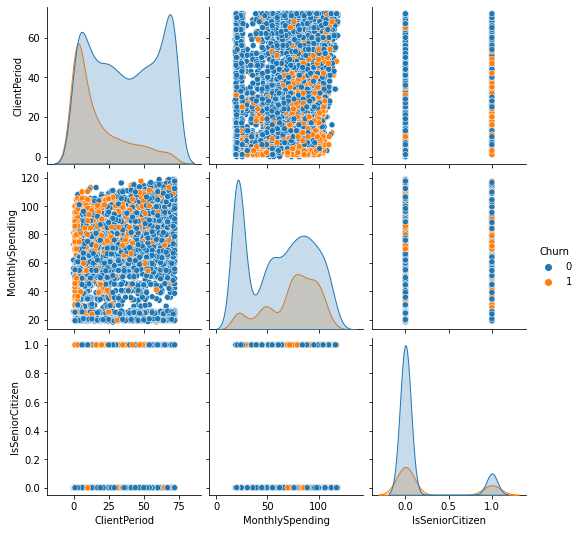

In [8]:
sns.pairplot(df, hue="Churn")

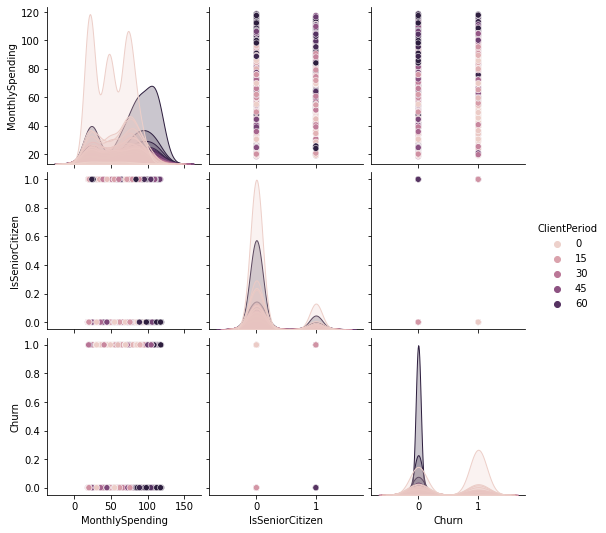

In [9]:
sns.pairplot(df, hue='ClientPeriod')

Линейные классификаторы будут явно плохи, поэтому использовать их не будем(только ради задания)

In [10]:
def obrabotka(df,result = False):
    if result == False:
        df['TotalSpent'] = df['TotalSpent'].replace(' ',1).astype(np.float16)
        df_ficha_number = df[['ClientPeriod','MonthlySpending','TotalSpent','Churn']]
        df_categorial_fich = pd.get_dummies(df.drop(['ClientPeriod','MonthlySpending','TotalSpent','Churn'],axis = 1))
        df = pd.concat([df_ficha_number,df_categorial_fich],sort = False, axis = 1)
        return df
    else:
        df['TotalSpent'] = df['TotalSpent'].replace(' ',1).astype(np.float16)
        df_ficha_number = df[['ClientPeriod','MonthlySpending','TotalSpent']]
        df_categorial_fich = pd.get_dummies(df.drop(['ClientPeriod','MonthlySpending','TotalSpent'],axis = 1))
        df = pd.concat([df_ficha_number,df_categorial_fich],sort = False, axis = 1)
        return df
        
        

In [11]:
full_df = obrabotka(df)

full_df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Churn,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55,19.50,1026.000,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.000,0,0,0,1,0,1,1,...,0,0,0,1,1,0,0,1,0,0
2,1,75.90,75.875,1,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,1,0
3,32,79.30,2570.000,0,1,1,0,0,1,1,...,0,1,0,0,1,0,0,0,0,1
4,60,115.25,6760.000,0,0,1,0,0,1,0,...,1,0,0,1,1,0,0,1,0,0


Количественное соотношения между элементами

Соотношение между величинами серьезное и составляет 2.81 раза

In [12]:
y = full_df["Churn"].astype(np.int64)

x = full_df.drop(["Churn"],axis=1)


произведем разбиение на тестовые и тренировочные данные ибо это нам позволяет размер
нашего Dataframe

In [13]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=5)


Реализуем функцию, которая будет обучать модель

In [14]:
def learn_model(clf,parametrs,X_train,y_train,X_test,y_test,learning):

    
    if learning == 'Yes':
        try:
            grid_search_cv = GridSearchCV(clf,
                                      param_grid=parametrs,
                                      scoring= 'roc_auc',
                                      cv = 5,
                                      n_jobs=-1,)
            grid_search_cv.fit(X_train,y_train)
        except Exception as ex:
            return "Read_documentation"
        
        try:
            best_model = grid_search_cv.best_estimator_
            best_model.fit(X_train,y_train)
        except Exception as ex:
            pass 
        plt.figure(figsize=(13,8))
        x,y,thresholds = roc_curve(y_true=y_test,y_score=best_model.predict(X_test))
        x1,y1,thresholds = roc_curve(y_true=y_train,y_score=best_model.predict(X_train))
        plt.plot(x,y,label = f'Total test roc_auc = {roc_auc_score(y_true=y_test,y_score=best_model.predict_proba(X_test)[:,1])}')
        plt.plot(x1,y1,label = f'Total train roc_auc = {roc_auc_score(y_true=y_train,y_score=best_model.predict_proba(X_train)[:,1])}')
        plt.title(f"Roc_auc {clf}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Negative Rate')
        plt.grid()
        plt.legend()
        ### для результа на kaggle
        print(best_model)
    else: 
        clf.fit(X_train,y_train)
        x,y,thresholds = roc_curve(y_true=y_test,y_score=clf.predict(X_test))
        x1,y1,thresholds = roc_curve(y_true=y_train,y_score=clf.predict(X_train))
        plt.figure(figsize=(13,8))
        plt.plot(x,y,label = f'Total test roc_auc = {roc_auc_score(y_true=y_test,y_score=clf.predict_proba(X_test)[:,1])}')
        plt.plot(x1,y1,label = f'Total train roc_auc = {roc_auc_score(y_true=y_train,y_score=clf.predict_proba(X_train)[:,1])}')
        plt.title(f"Roc_auc {clf}")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Negative Rate')
        plt.grid()
        plt.legend()
    
    
    
    
    
    
    
    

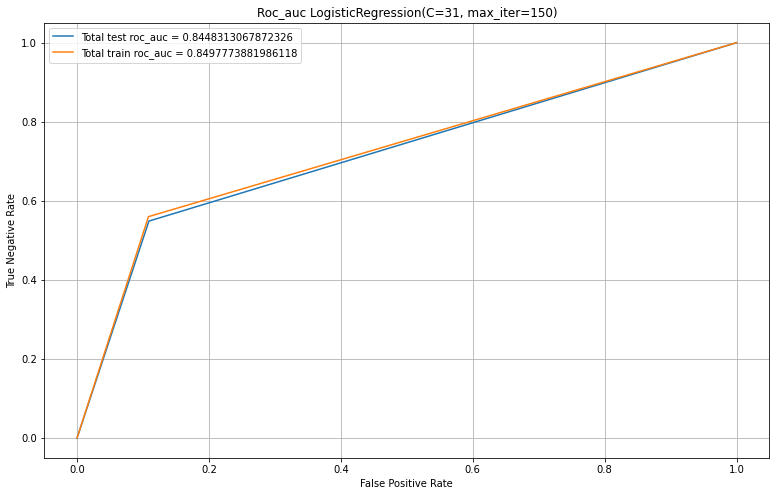

In [15]:
clf0 = LogisticRegression(max_iter=150)
grid_values = {'penalty': ['l1','l2'], 
               'C': np.arange(1,200,10)} 

log_reg_cv = GridSearchCV(clf0,
                        param_grid=grid_values,
                        scoring='roc_auc',
                         cv = 5,
                         n_jobs=-1)


log_reg_cv.fit(X_train,y_train)
best_log_reg = log_reg_cv.best_estimator_
best_log_reg.fit(X_train,y_train)

x,y,thresholds = roc_curve(y_true=y_test,y_score=best_log_reg.predict(X_test))
x1,y1,thresholds = roc_curve(y_true=y_train,y_score=best_log_reg.predict(X_train))
plt.figure(figsize = (13,8))
plt.plot(x,y,label = f'Total test roc_auc = {roc_auc_score(y_true=y_test,y_score=best_log_reg.predict_proba(X_test)[:,1])}')
plt.plot(x1,y1,label = f'Total train roc_auc = {roc_auc_score(y_true=y_train,y_score=best_log_reg.predict_proba(X_train)[:,1])}')
plt.title(f"Roc_auc {best_log_reg}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Negative Rate')
plt.grid()
plt.legend()



Параметры лучшей LogisticRegression()

In [16]:
log_reg_cv.best_params_

{'C': 31, 'penalty': 'l2'}

In [17]:
print(f"AUC Score: {roc_auc_score(y_true=y_test,y_score=best_log_reg.predict_proba(X_test)[:,1])}")

AUC Score: 0.8448313067872326


DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2,
                       min_samples_split=3)


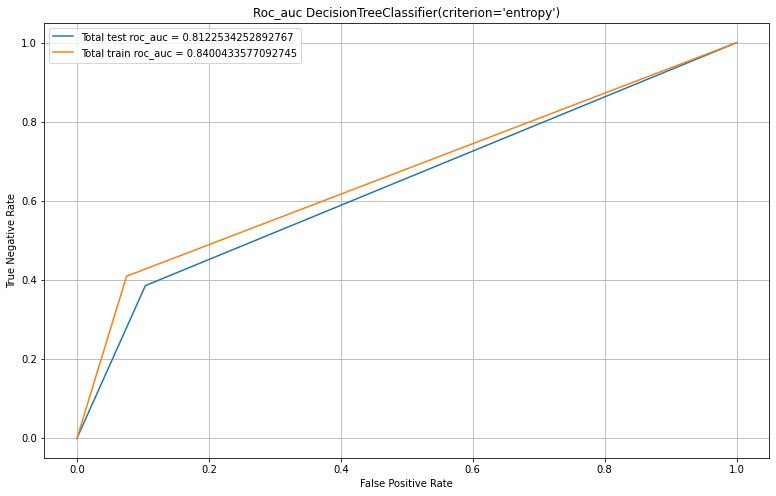

In [18]:
clf = DecisionTreeClassifier(criterion='entropy')

parametrs = {"max_depth":np.arange(1,5),
            'min_samples_split':np.arange(2,5),
            "min_samples_leaf":np.arange(2,5)}

cat = learn_model(clf,parametrs, X_train,y_train,X_test,y_test,learning= 'Yes')

Лучшая модель

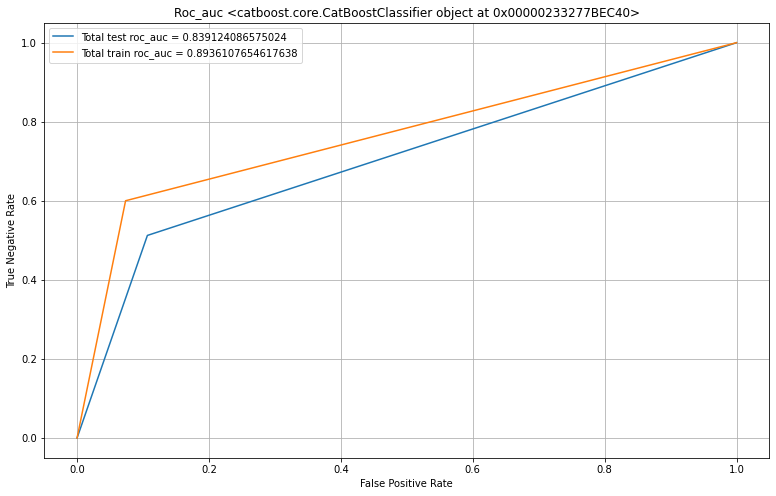

In [19]:
clf1 = CatBoostClassifier(iterations=450,
                       depth=4,
                       learning_rate=0.05,
                       loss_function='Logloss',
                       verbose=False,
                       random_seed = 14,
                       l2_leaf_reg = 40,
                       eval_metric='AUC')

parametrs1 = {"max_depth":np.arange(1,5),
            'min_samples_split':np.arange(2,5),
            "min_samples_leaf":np.arange(2,5)}

cat = learn_model(clf1,parametrs, X_train,y_train,X_test,y_test,learning="No")

Результат на 1 балл

Пора обучить целый лес

RandomForestClassifier(max_depth=4, min_samples_leaf=4)


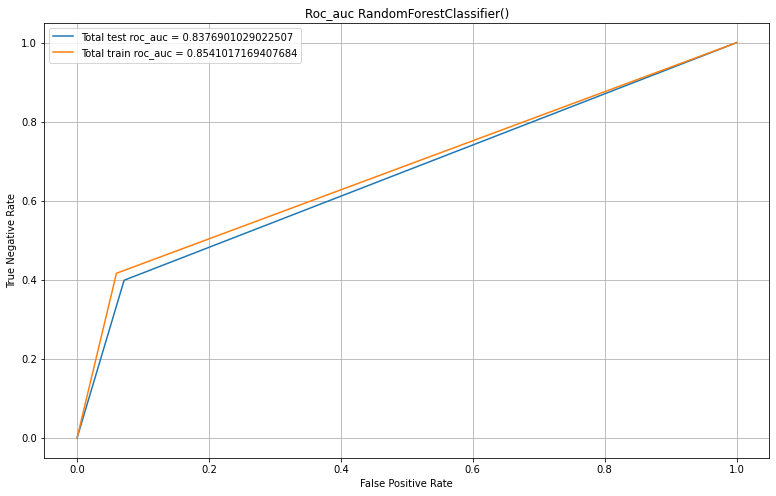

In [20]:
clf2 = RandomForestClassifier()

forest = learn_model(clf2,parametrs, X_train,y_train,X_test,y_test,learning="Yes")

Алгоритм XGBoost: пусть он царствует долго!

GradientBoostingClassifier(max_depth=1, min_samples_leaf=4, n_estimators=201)


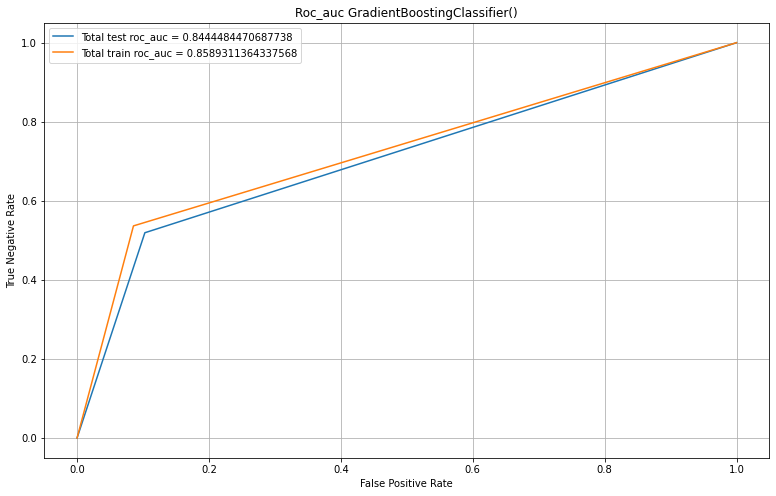

In [21]:
clf3  = GradientBoostingClassifier()
parametrs1 = {"max_depth":np.arange(1,4),
            'min_samples_split':np.arange(2,5),
            "min_samples_leaf":np.arange(2,5),
             'learning_rate':np.array([0.1,0.2,0.3,0.4]),
                  'n_estimators':np.arange(1,500,100)
             }

grad_boosting = learn_model(clf3,parametrs1, X_train,y_train,X_test,y_test,learning="Yes")

Попробую новый Классификатор 

[16:59:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:59:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to 

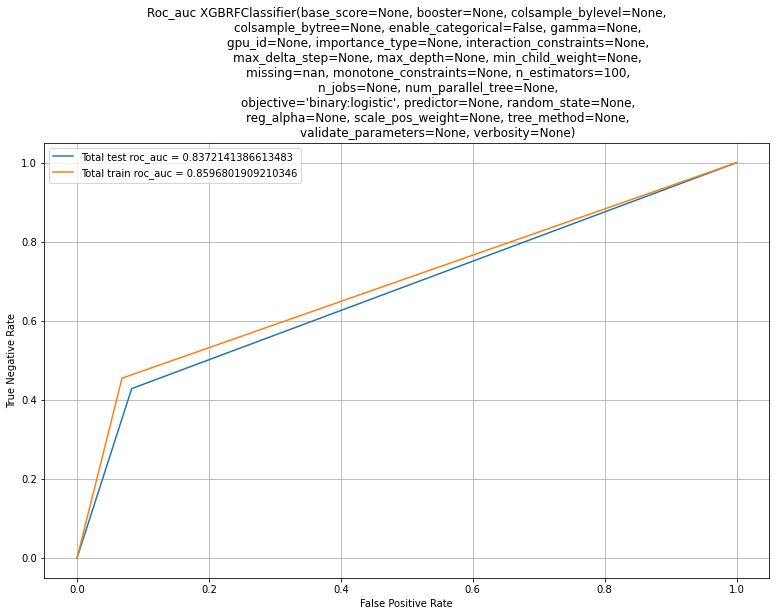

In [22]:
clf4  = XGBRFClassifier()
parametrs1 = {"max_depth":np.arange(1,5),
            'min_samples_split':np.arange(2,5),
            "min_samples_leaf":np.arange(2,5)}

boosting = learn_model(clf4,parametrs1, X_train,y_train,X_test,y_test,learning="Yes")



In [23]:
clf1 = GradientBoostingClassifier(learning_rate=0.25, max_depth=1, min_samples_leaf=4,
                           n_estimators=90)
clf1.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.25, max_depth=1, min_samples_leaf=4,
                           n_estimators=90)

Пора протестироваться на Kaggle

In [24]:
y_finall_test = pd.read_csv('test.csv')

y_finall_test = obrabotka(y_finall_test,result=True)

In [25]:
y_finall_test.head()


,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,42,56.10,2386.0,0,0,1,0,1,1,0,...,0,0,1,0,1,0,0,1,0,0
1,29,98.50,3004.0,1,0,1,0,1,1,0,...,1,1,0,0,0,1,0,0,1,0
2,9,76.25,685.0,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,67,74.00,4868.0,0,1,0,0,1,0,1,...,0,0,0,1,1,0,0,1,0,0
4,71,20.10,1390.0,0,1,0,0,1,0,1,...,0,0,0,1,1,0,1,0,0,0


In [26]:
my_answer = pd.DataFrame({
    "Churn":clf1.predict_proba(y_finall_test)[:,1]
    })

my_answer.index.name = 'id'
my_answer.shape

(1761, 1)

In [27]:
my_answer.to_csv('answer')

На Kaggle, градиентный бустинг дал  Score: 0.85290, подняв меня на 317 место
Moй ник Like Boss